In [1]:
#install pandas data reader package
!pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf


# <font face="gotham" color="purple"> Хугацаан цувааны өгөгдлийг боловсруулах </font>

Энэ хэсэг нь Python дээр, ялангуяа pandas ашиглан хугацаан цувааны өгөгдлүүдтэй ажиллах юм

АНУ-ын нэг хүнд ногдох бодит ДНБ.

In [3]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2023,12, 1)
df = pdr.data.DataReader(['A939RX0Q048SBEA'], 'fred' , start, end)  #download data from the package
df.columns = ['R_GDP_PerCap']
df['R_GDP_PerCap_tm1'] = df['R_GDP_PerCap'].shift(1)
df = df.dropna()
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1
DATE,,
1950-04-01,15977.0,15559.0
1950-07-01,16524.0,15977.0
1950-10-01,16764.0,16524.0
1951-01-01,16922.0,16764.0
1951-04-01,17147.0,16922.0


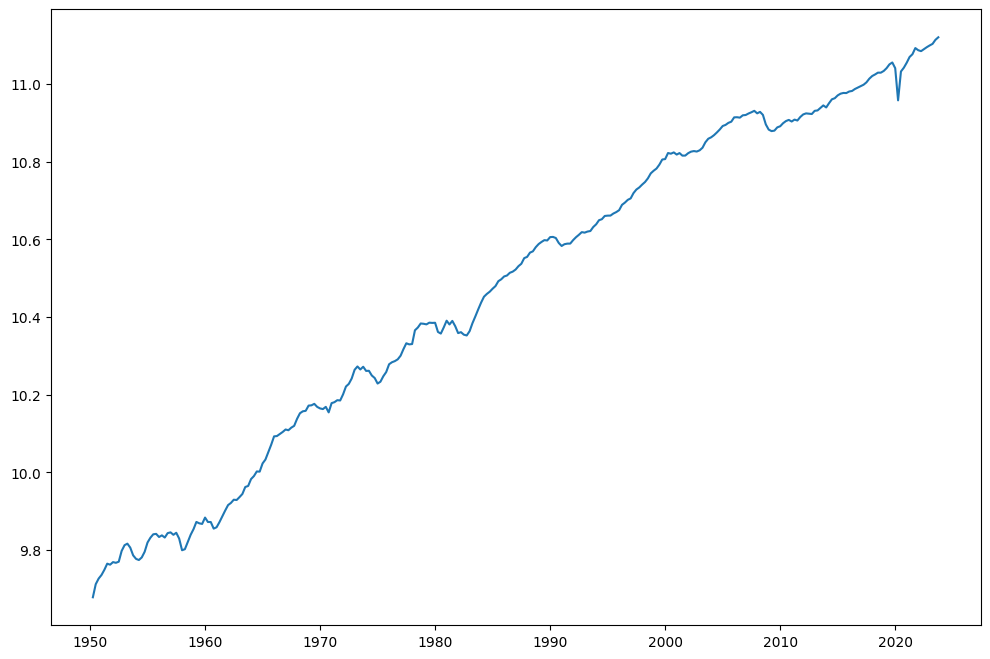

In [4]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(np.log(df['R_GDP_PerCap']))
plt.show()

In [5]:
pd.options.mode.chained_assignment = None 
df['Gr_rate'] = df['R_GDP_PerCap']/df['R_GDP_PerCap_tm1']
df['Gr_rate'] = df['Gr_rate']-1
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate
DATE,,,
1950-04-01,15977.0,15559.0,0.026865
1950-07-01,16524.0,15977.0,0.034237
1950-10-01,16764.0,16524.0,0.014524
1951-01-01,16922.0,16764.0,0.009425
1951-04-01,17147.0,16922.0,0.013296


In [6]:
#gdp growth
df['Gr_rate_log_approx'] = np.log(df['R_GDP_PerCap']) - np.log(df['R_GDP_PerCap_tm1'])
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx
DATE,,,,
1950-04-01,15977.0,15559.0,0.026865,0.026511
1950-07-01,16524.0,15977.0,0.034237,0.033664
1950-10-01,16764.0,16524.0,0.014524,0.014420
1951-01-01,16922.0,16764.0,0.009425,0.009381
1951-04-01,17147.0,16922.0,0.013296,0.013209


Нэг хүнд ногдох ДНБ-ийн өсөлтийн график $g_t = \frac{y_t}{y_{t-1}}-1$ болон логирифмын ялгавар $g_t\approx \ln{y_t}-\ln{y_{t-1}} $

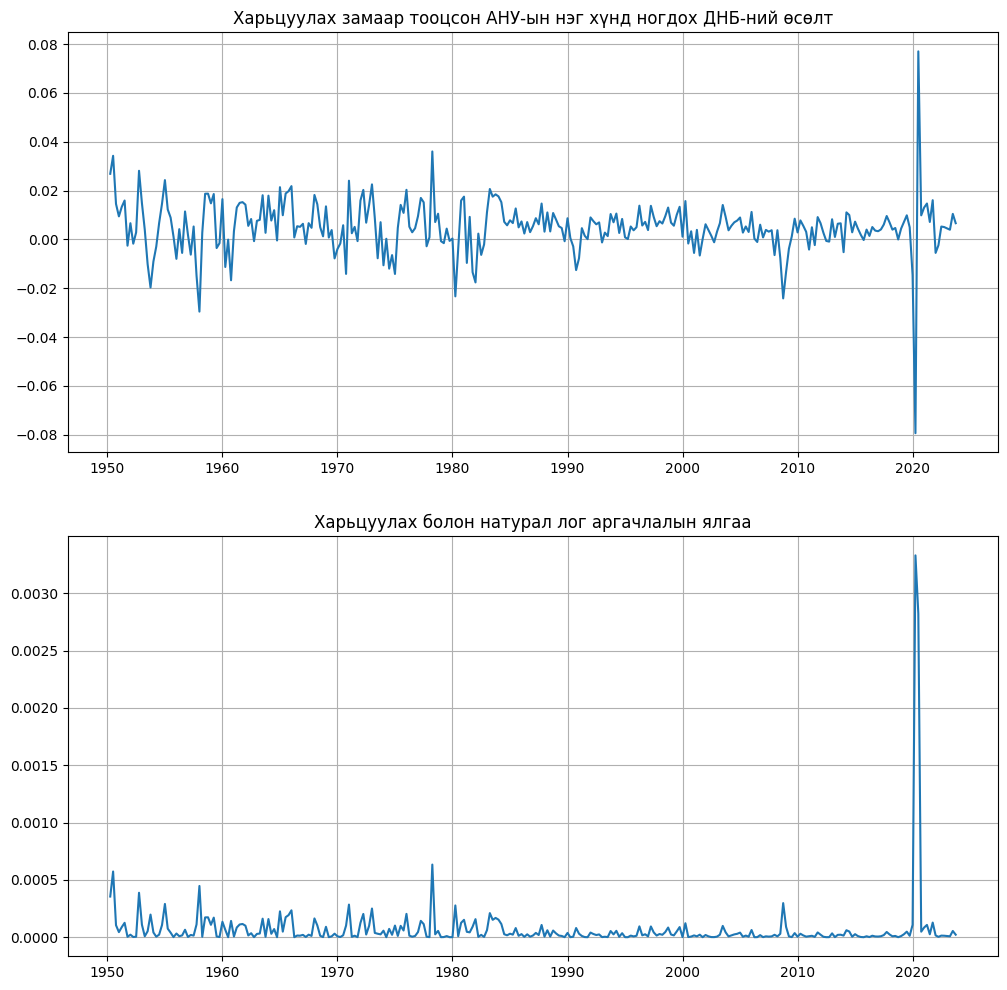

In [7]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))
ax[0].plot(df['Gr_rate'])
ax[0].grid()
ax[0].set_title('Харьцуулах замаар тооцсон АНУ-ын нэг хүнд ногдох ДНБ-ний өсөлт')
ax[1].plot(df['Gr_rate']- df['Gr_rate_log_approx'])
ax[1].grid()
ax[1].set_title('Харьцуулах болон натурал лог аргачлалын ялгаа')
plt.show()

In [8]:
max(df['Gr_rate'])

0.07702629698691243

In [9]:
max(df['Gr_rate_log_approx'])

0.07420381476280546

Тооцооллын зөрүүнээс харахад логирифм өсөлтийн хурд нь энгийн өсөлтийн хурдаас үргэлж доогуур байдаг бөгөөд  1980-аад оноос хойшхи хугацаанд лог зөрүү нь бодит өсөлтийн хурдтай ойролцоо байна. Цорын ганц үл хамаарах зүйл бол Ковид тахлын үеийн сэргэлт байна.

## <font face="gotham" color="purple"> Натурал логирифм хувиргалт хэр найдвартай вэ?</font>

Бид $0$-аас $0.8$ хүртэлх $.01$-ийн алхамтай цувааг үүсгэсэн бөгөөд энэ нь $0\%$-аас $80 хүртэлх өсөлтийн хурдтай гэсэн үг юм. Эхний зураг дээр бодит өсөлт болон натурал лог аргын харьцуулалт бөгөөд өсөлтийн хурд нэмэгдэх тусам зөрүү нь өндөр болж байна.

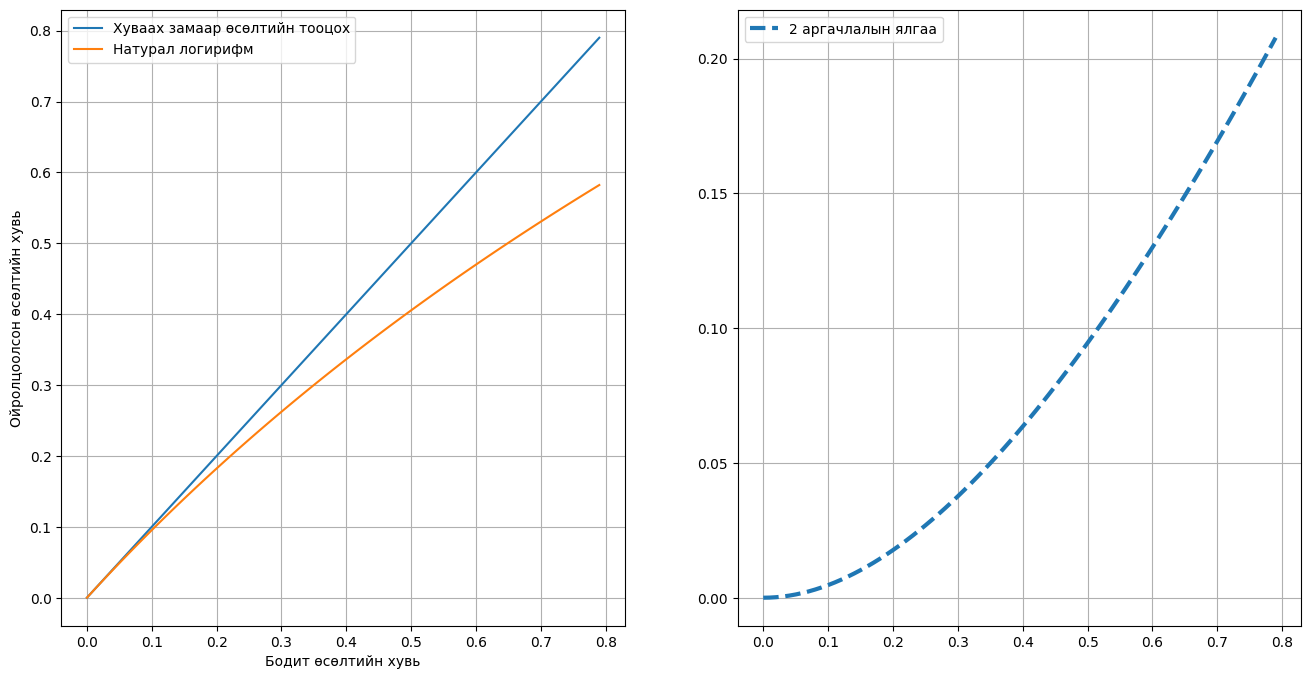

In [10]:
g = np.arange(0, .8, .01)
log_g = np.log(1+g)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
ax[0].plot(g, g, label = 'Хуваах замаар өсөлтийн тооцох')
ax[0].plot(g, log_g, label = 'Натурал логирифм')
ax[0].set_xlabel('Бодит өсөлтийн хувь')
ax[0].set_ylabel('Ойролцоолсон өсөлтийн хувь')
ax[0].grid()
ax[0].legend()

ax[1].plot(g, g - log_g, ls = '--', lw = 3, label = '2 аргачлалын ялгаа')
ax[1].grid()
ax[1].legend()
plt.show()

## <font face="gotham" color="purple"> Жилийн өсөлтийн хэрхэн тооцоолох вэ? </font>

Улирлын өсөлтийг тооцоолох нь:
$$
g_{YoY, 2023}=\frac{y_{3Q2023}}{y_{3Q2022}}-1
$$
энд $y_{3Q2023}$ нь $2023$ оны  $3$-р улирлын ДНБ, $y_{3Q2022}$-ны ДНБ.

In [11]:
df['R_GDP_PerCap_tm4'] = df['R_GDP_PerCap'].shift(4)
df = df.dropna()
df

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4
DATE,,,,,
1951-04-01,17147.0,16922.0,0.013296,0.013209,15977.0
1951-07-01,17420.0,17147.0,0.015921,0.015796,16524.0
1951-10-01,17375.0,17420.0,-0.002583,-0.002587,16764.0
1952-01-01,17490.0,17375.0,0.006619,0.006597,16922.0
1952-04-01,17459.0,17490.0,-0.001772,-0.001774,17147.0
...,...,...,...,...,...
2022-10-01,65799.0,65469.0,0.005041,0.005028,65648.0
2023-01-01,66096.0,65799.0,0.004514,0.004504,65284.0
2023-04-01,66357.0,66096.0,0.003949,0.003941,65127.0


In [12]:
df['Gr_rate_log_approx_YoY'] = np.log(df['R_GDP_PerCap']) - np.log(df['R_GDP_PerCap_tm4'])
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4,Gr_rate_log_approx_YoY
DATE,,,,,,
1951-04-01,17147.0,16922.0,0.013296,0.013209,15977.0,0.070673
1951-07-01,17420.0,17147.0,0.015921,0.015796,16524.0,0.052805
1951-10-01,17375.0,17420.0,-0.002583,-0.002587,16764.0,0.035799
1952-01-01,17490.0,17375.0,0.006619,0.006597,16922.0,0.033015
1952-04-01,17459.0,17490.0,-0.001772,-0.001774,17147.0,0.018032


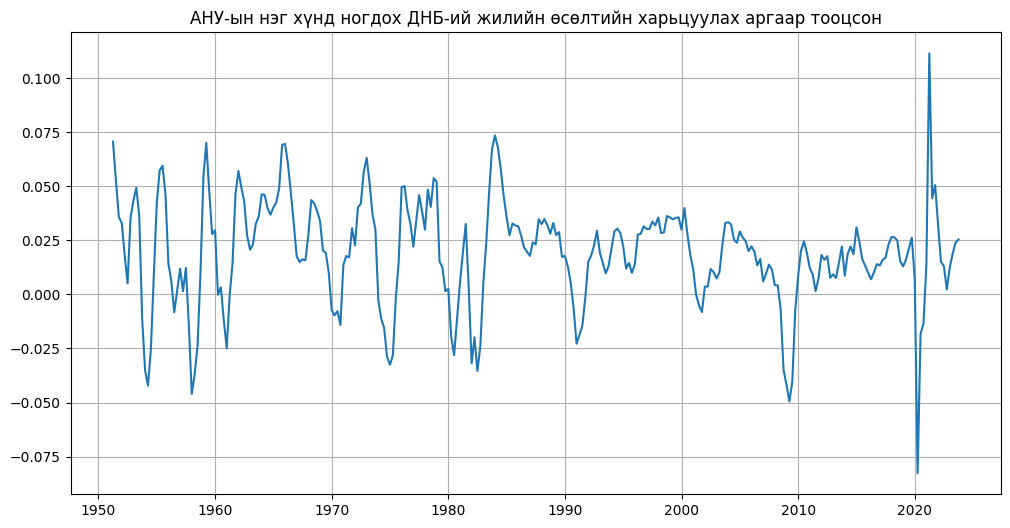

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(df['Gr_rate_log_approx_YoY'])
ax.grid()
ax.set_title('АНУ-ын нэг хүнд ногдох ДНБ-ий жилийн өсөлтийн харьцуулах аргаар тооцсон')
plt.show()

## <font face="gotham" color="purple"> Хугацаан цувааны өгөгдлөөс түүвэр авах </font>

**Дахин түүвэрлэх** замаар бид хугацаан цувааг **upsample** буюу илүү богино давтамжтай цувааруу хөрвүүлэх эсвэл цувааг  **downsample** буюу давтамжтай цувааруу түүвэрлэж болно. 

Жишээлбэл,  нэг өгөгдөл нь жилийн давтамжтай, харин бусад өгөгдөл нь улирал тутам байдаг бол энэ жилийн өгөгдлийг бусадтай нэгтгэхийн тулд  улирлын өгөгдөл болгон түүвэрлэх ёстой болно

Нэг хүнд ногдох нэрлэсэн ДНБ-ийг оруулж ирье:

In [14]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2021,10, 1)
df = pdr.data.DataReader(['A939RC0A052NBEA'], 'fred' , start, end)
df.columns = ['Nom_GDP_PerCap_Annual']
df = df.dropna()
df.head()

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.0
1951-01-01,2248.0
1952-01-01,2340.0
1953-01-01,2439.0
1954-01-01,2405.0


In [15]:
df_us_Q = df.resample('QS').interpolate(method='linear')
df_us_Q.head()

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.00
1950-04-01,2044.75
1950-07-01,2112.50
1950-10-01,2180.25
1951-01-01,2248.00


Өдрийн өгөгдлийг сарлуу хөрвүүлэх

In [16]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2021,10, 1)
df = pdr.data.DataReader(['DEXCHUS'], 'fred' , start, end) #валютын ханш
df.columns = ['USDCNY']
df = df.dropna()
df.head()

,USDCNY
DATE,
2010-01-04,6.8273
2010-01-05,6.8258
2010-01-06,6.8272
2010-01-07,6.8280
2010-01-08,6.8274


In [17]:
df_M = df.resample('M').mean()
df_M.head()

,USDCNY
DATE,
2010-01-31,6.826916
2010-02-28,6.828463
2010-03-31,6.826183
2010-04-30,6.825550
2010-05-31,6.827450


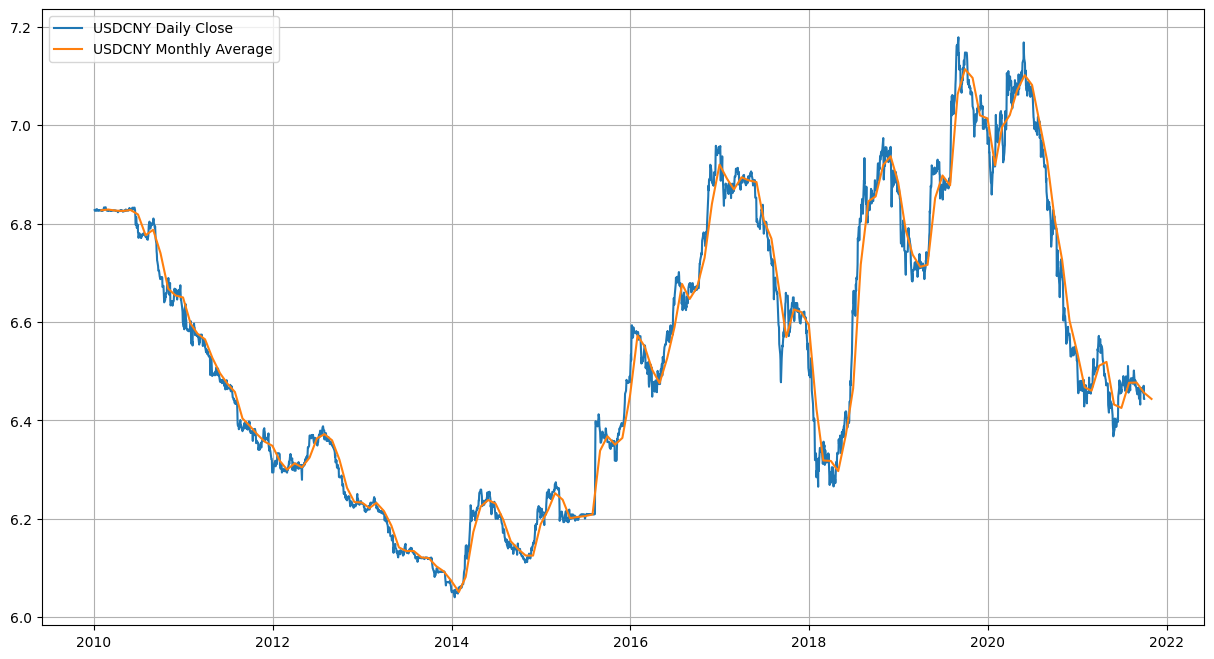

In [18]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(df['USDCNY'], label = 'USDCNY Daily Close')
ax.plot(df_M['USDCNY'], label = 'USDCNY Monthly Average')
ax.grid()
ax.legend()
plt.show()

pandas сангийн хугацаан цувааны өгөгдлийг давтамжууд:

```
B         business day frequency
C         custom business day frequency (experimental)
D         calendar day frequency
W         weekly frequency
M         month end frequency
SM        semi-month end frequency (15th and end of month)
BM        business month end frequency
CBM       custom business month end frequency
MS        month start frequency
SMS       semi-month start frequency (1st and 15th)
BMS       business month start frequency
CBMS      custom business month start frequency
Q         quarter end frequency
BQ        business quarter endfrequency
QS        quarter start frequency
BQS       business quarter start frequency
A         year end frequency
BA, BY    business year end frequency
AS, YS    year start frequency
BAS, BYS  business year start frequency
BH        business hour frequency
H         hourly frequency
T, min    minutely frequency
S         secondly frequency
L, ms     milliseconds
U, us     microseconds
N         nanoseconds
```

## <font face="gotham" color="purple"> Хугацаан цувааны трендийг арилгах </font>

Хэрэглээний макро эдийн засагт трендийг арилгах хамгийн түгээмэл арга бол **Hodrick-Prescott filter** бөгөөд $y_t$ хугацаан цувааг тренд, улирлын нөлөө болон санасаргүй хэсгүүдэд хувааж болно гэж үздэг.
$$
y_t = \tau_t+c_t
$$
энд $\tau$ бол тренд, $c$ бол улирлын нөлөө.

Трендийг илрүүлэхийн тулд $\tau$-аас хамааралтай дараах функцийг минимумчлана
$$
\min _{\tau}\left(\sum_{t=1}^{T}\left(y_{t}-\tau_{t}\right)^{2}+\lambda \sum_{t=2}^{T-1}\left[\left(\tau_{t+1}-\tau_{t}\right)-\left(\tau_{t}-\tau_{t-1}\right)\right]^{2}\right)
$$

Ерөнхийдөө, $\lambda$-ийн утгыг дараах байдлаар авч үздэг: 
\begin{align}
&\text{Annual}: 6.25 \\
&\text{Quarter}: 1600\\
&\text{Month}: 129600
\end{align}

In [19]:
USDCNY_cycle, USDCNY_trend = hpfilter(np.log(df['USDCNY']), lamb=10000000)

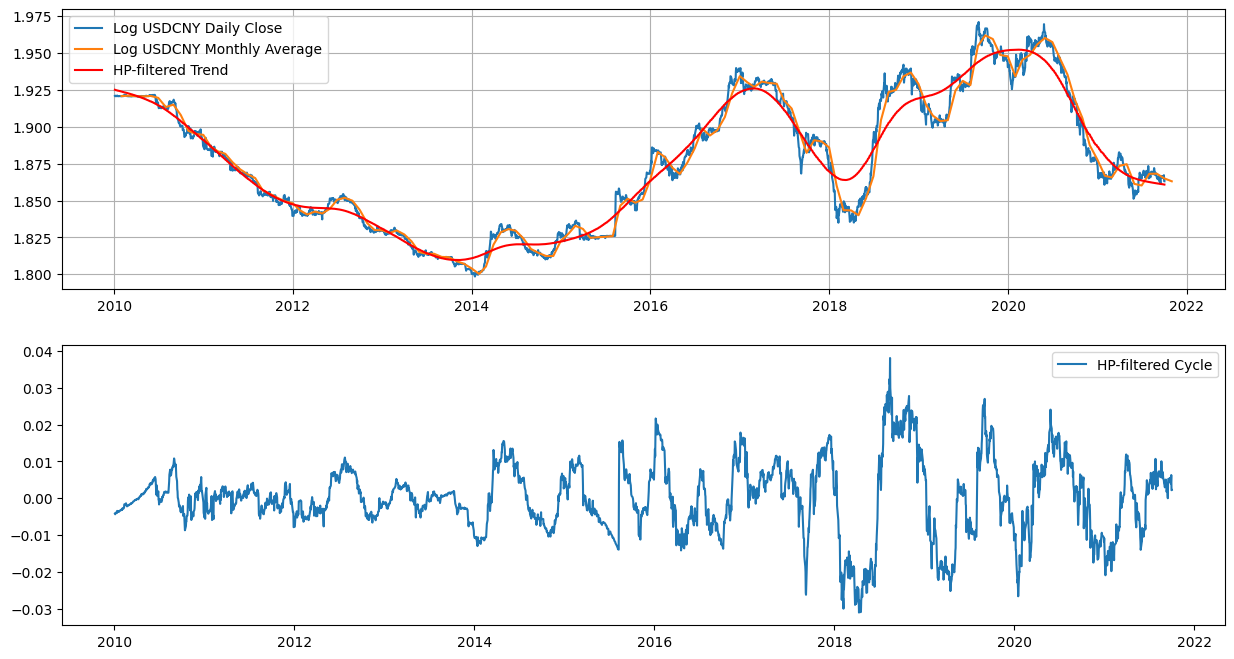

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8))
ax[0].plot(np.log(df['USDCNY']), label = 'Log USDCNY Daily Close')
ax[0].plot(np.log(df_M['USDCNY']), label = 'Log USDCNY Monthly Average')
ax[0].plot(USDCNY_trend, color = 'red', label = 'HP-filtered Trend')
ax[0].grid()
ax[0].legend()

ax[1].plot(USDCNY_cycle, label = 'HP-filtered Cycle')
ax[1].legend()
plt.show()

# <font face="gotham" color="purple"> Dynamic Econometric Models </font>

Бид эконометрикт хоёр төрлийн загварыг авч үздэг: **distributed-lag model** and **autogressive model**. 

## <font face="gotham" color="purple"> Distributed-Lag Model (DLM) </font>

Энд DLM загвар нь $X$-ийн лагуудаас хамааралтай байж болно.
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{1} X_{t-1}+\beta_{2} X_{t-2}+\cdots+u_{t}
$$

### <font face="gotham" color="purple"> Ad Hoc Estimation Of DLM </font>

Хэрэв эдийн засгийн тодорхой хамааралгүй эсвэл онолын үндэслэлгүй хувьсагчдыг загварт оруулж байгаа бол Ad Hoc аргачлалыг ашиглана. Энэ нь хувьсагчийн лаг-ийг нэг нэгээр нэмэгдүүлэх техник юм. Ийнхүү регрессийн коэффициентийн ач холбогдол болон бусад статистикт үндэслэн үр дүнг гаргана.

\begin{align}
\hat{Y}_t &= a + b_0X_t\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_2X_{t-2}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_1X_{t-1}+b_3X_{t-3}\\
\end{align}

### <font face="gotham" color="purple"> Koyck Approach To DLM </font>

Koyck аргачлал нь $\beta$-үүд нь ижил нөлөөтэй байна гэж үздэг тул доорх таамаглалыг авч үздэг.
$$
\beta_{k}=\beta_{0} \lambda^{k} \quad k=0,1, \ldots
$$
энд $\lambda$ нь 0-оос 1-н хооронд байна $0<\lambda<1$.

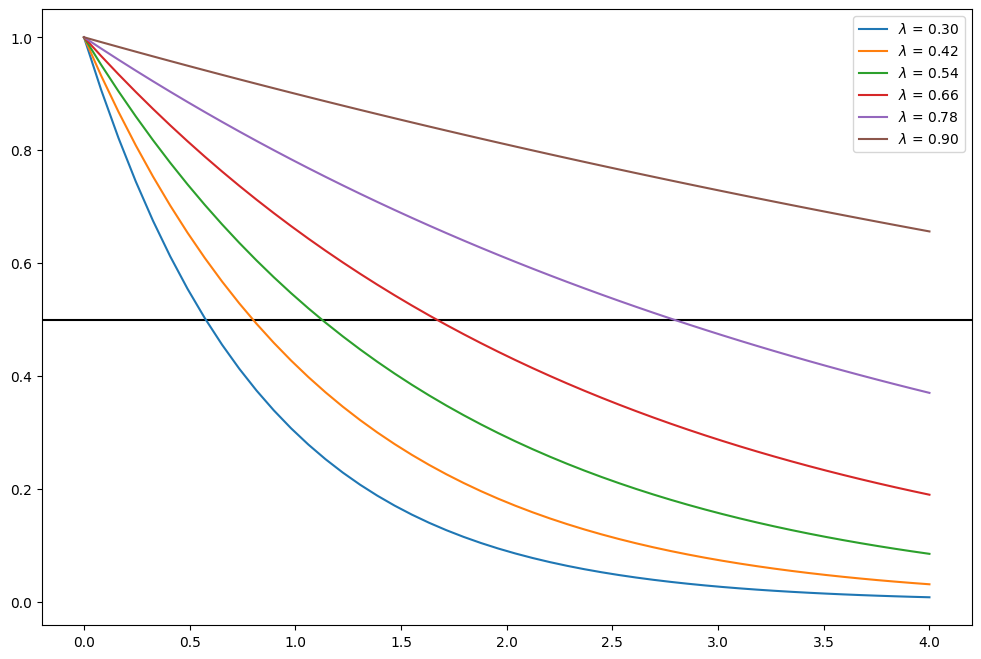

In [21]:
lamda = np.linspace(0.3, .9, 6)
beta_0 = 1
k = np.linspace(0, 4)
fig, ax = plt.subplots(figsize = (12, 8))
for i in lamda:
    beta_k = beta_0*i**k
    ax.plot(k, beta_k, label = '$\lambda$ = %.2f'%i)
ax.legend()
ax.axhline(y = 0.5, zorder = -10, color = 'k')
plt.show()

### <font face="gotham" color="purple"> Хэрэглээ ба орлогын жишээ </font>

FRED-ээс зардал болон орлогыг татаж болно $PCE$ бол _real personal consumption expenditure_ and $DI$ бол _real disposable income per capita_. 

In [22]:
start = dt.datetime(2002, 1, 1)
end = dt.datetime(2023,12, 1)
df_exp = pdr.data.DataReader(['PCEC96','A229RX0'], 'fred' , start, end)
df_exp.columns = ['PCE', 'DI']
df_exp = df_exp.dropna()
df_exp.head()

,PCE,DI
DATE,,
2007-01-01,11181.0,39803.0
2007-02-01,11178.2,39906.0
2007-03-01,11190.7,40007.0
2007-04-01,11201.5,40037.0
2007-05-01,11218.0,40029.0


In [23]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

ЗАГВАР:
$$
PCE_t = \alpha(1-\lambda) + \beta_0 DI_t + \lambda PCE_{t-1}+ v_t
$$

In [24]:
DLM = smf.ols(formula = 'PCE ~ 1 + lag(DI, 0) + lag(PCE, 1)', data = df_exp)
DLM_results = DLM.fit()
print(DLM_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     7870.
Date:                Tue, 27 Feb 2024   Prob (F-statistic):          7.13e-191
Time:                        12:01:01   Log-Likelihood:                -1313.2
No. Observations:                 203   AIC:                             2632.
Df Residuals:                     200   BIC:                             2642.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -193.4230    123.426     -1.567      

ҮНЭЛЭГДСЭН ҮР ДҮН:

In [25]:
beta_0 = DLM_results.params[1]
lamda = DLM_results.params[2]
alpha = DLM_results.params[0]/(1-DLM_results.params[2])

print('beta_0 = {}'.format(beta_0))
print('lambda = {}'.format(lamda))
print('alpha = {}'.format(alpha))

beta_0 = 0.01843335069058369
lambda = 0.9531581222079705
alpha = -4129.275889234852


Дурын $\beta_k$-ын хувьд $\beta_{k}=\beta_{0} \lambda^{k}$

In [26]:
def beta_k(lamda, k, beta_0):
    return beta_0 * lamda**k

In [27]:
beta_k(lamda, 1, beta_0)

0.017569897930237745

Өгөгдсөн урт хугацааны үржүүлэгч $\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)$

In [28]:
beta_0*(1/(1-lamda))

0.3935228807953607

In [29]:
1/(1-lamda)

21.348418277333813

Дундаж лаг, эхний хагасыг задлахад шаардагдах лаг. Бидний жишээнээс үзвэл, $PCE$ нь $DI$-д ихээхэн хоцрогдолтойгоор нөлөөлж, ойролцоогоор 9 сарын хугацаанд нөлөөлнө.

In [30]:
-np.log(2)/np.log(lamda)

14.448251340388177

Mean lag

In [31]:
lamda/(1-lamda)

20.348418277333813

# <font face="gotham" color="purple"> Stochastic Processes </font>

Cтохастик процессууд нь цаг хугацаагаар индексжүүлсэн санамсаргүй хэмжигдэхүүнүүдийн бүлгийг судалдаг математикийн салбар юм. Хугацаан цувааны өгөгдөл нь стохастик үйл явцын цуваа байдаг.
Жишээлбэл,  ДНБ-ийг Y гэж тэмдэглэвэл, энэ нь стохастик процесс бөгөөд Y1 ба Y2 нь хоёр өөр санамсаргүй хэмжигдэхүүн бөгөөд хэрэв Y1 = 1235 бол энэ нь t1-ийн санамсаргүй хэмжигдэхүүн юм. 

## <font face="gotham" color="purple"> Stationary Stochastic Processes </font>

Хэрэв түүний дундаж ба дисперс нь цаг хугацааны явцад тогтмол бөгөөд хоёр хугацааны хоорондох ковариацын утга нь зөвхөн хоёр хугацааны хоорондох зайнаас хамаарах ба ковариацыг тооцоолох бодит хугацаанаас хамаарахгүй бол стохастик процессыг стационар гэж нэрлэдэг.

\begin{align}
Mean:& \quad E\left(Y_{t}\right)=\mu\\
Variance:&\quad E\left(Y_{t}-\mu\right)^{2}=\sigma^{2}\\
Covariance:&\quad E\left[\left(Y_{t}-\mu\right)\left(Y_{t+k}-\mu\right)\right] = \gamma_{k}
\end{align}

## <font face="gotham" color="purple"> Nonstationary Stochastic Processes </font>

Nonstationary үйл явцын хамгийн түгээмэл төрөл нь **random walk** бөгөөд хоёр төрлийн байна:  **drift**-тэй болон **drift**-гүй

### <font face="gotham" color="purple"> Drift-тэй Random Walk </font>

In [32]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2023,12, 1)
df_eurusd = pdr.data.DataReader(['DEXUSEU'], 'fred' , start, end)
df_eurusd.columns = ['EURUSD']
df_eurusd = df_eurusd.dropna()

In [33]:
def rw_wdr(init_val, length):
    rw_array = []
    rw_array.append(init_val)
    
    last = init_val
    for i in range(length):
        current = last + np.random.randn()/100
        rw_array.append(current)
        last = current
    return rw_array

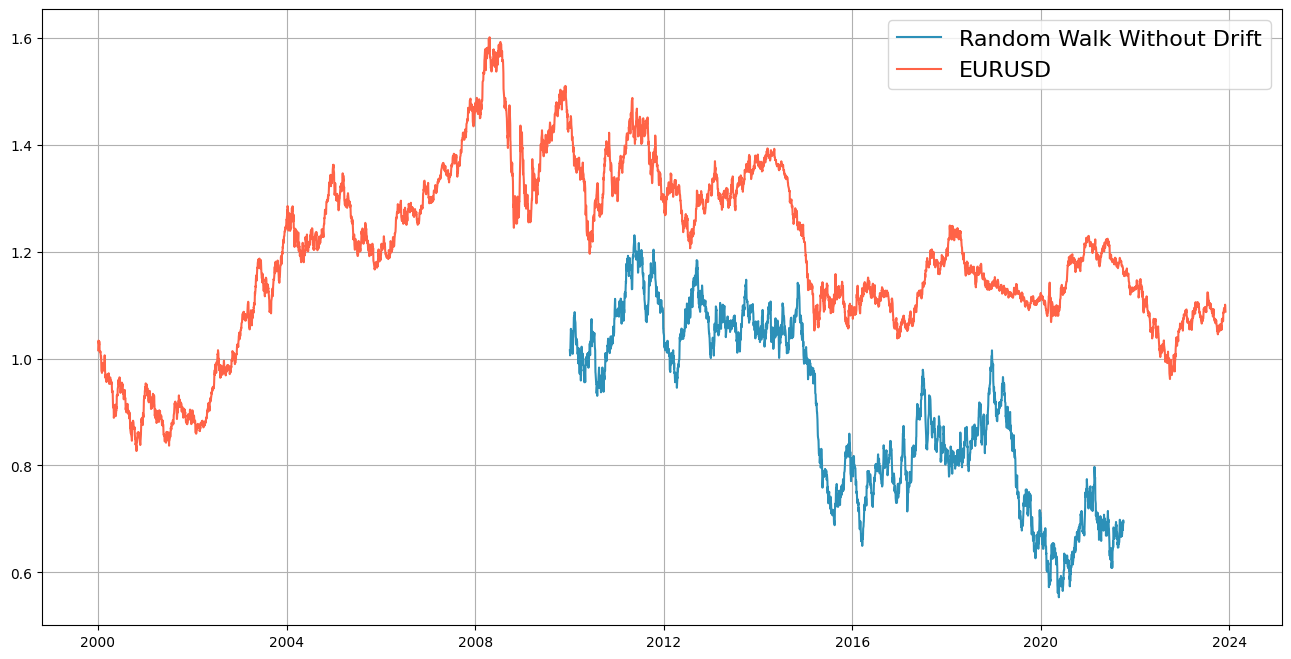

In [34]:
rw = rw_wdr(1.0155, len(df.index)-1)
df_rw = pd.DataFrame(rw, index = df.index, columns = ['Simulated Asset Price'])
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(df_rw, color = '#2c90b8', label = 'Random Walk Without Drift')
ax.plot(df_eurusd, color = 'tomato', label = 'EURUSD')
ax.grid()
ax.legend(fontsize = 16)
plt.show()

Нэгдүгээр зэргийн ялгавар нь:

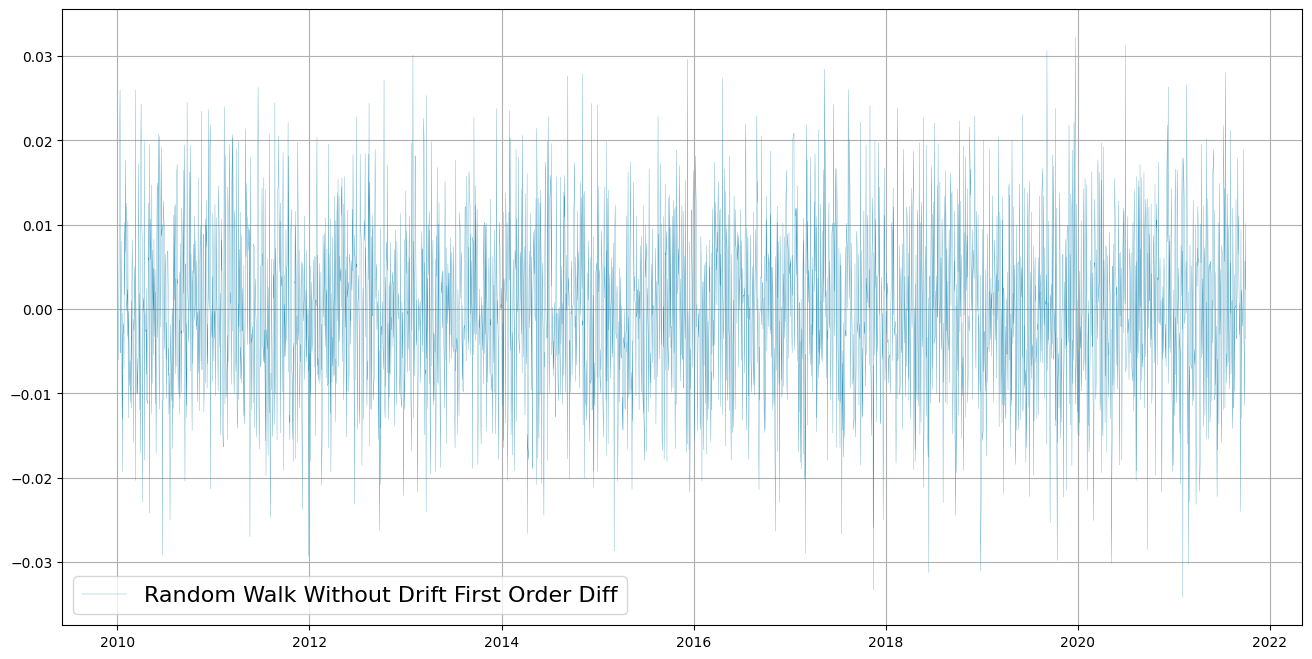

In [35]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(df_rw.diff().dropna(), color = '#2c90b8', label = 'Random Walk Without Drift First Order Diff', lw =.2)
ax.grid()
ax.legend(fontsize = 16)
plt.show()

### <font face="gotham" color="purple"> Random Walk With Drift </font>

In [36]:
def rw_dr(dr_param, init_val, length):
    rw_array = []
    rw_array.append(init_val)
    
    last = init_val
    for i in range(length):
        current = dr_param + last + 50*np.random.randn()
        rw_array.append(current)
        last = current
    return rw_array

In [37]:
rw = rw_dr(5, 1, len(df.index)-1)

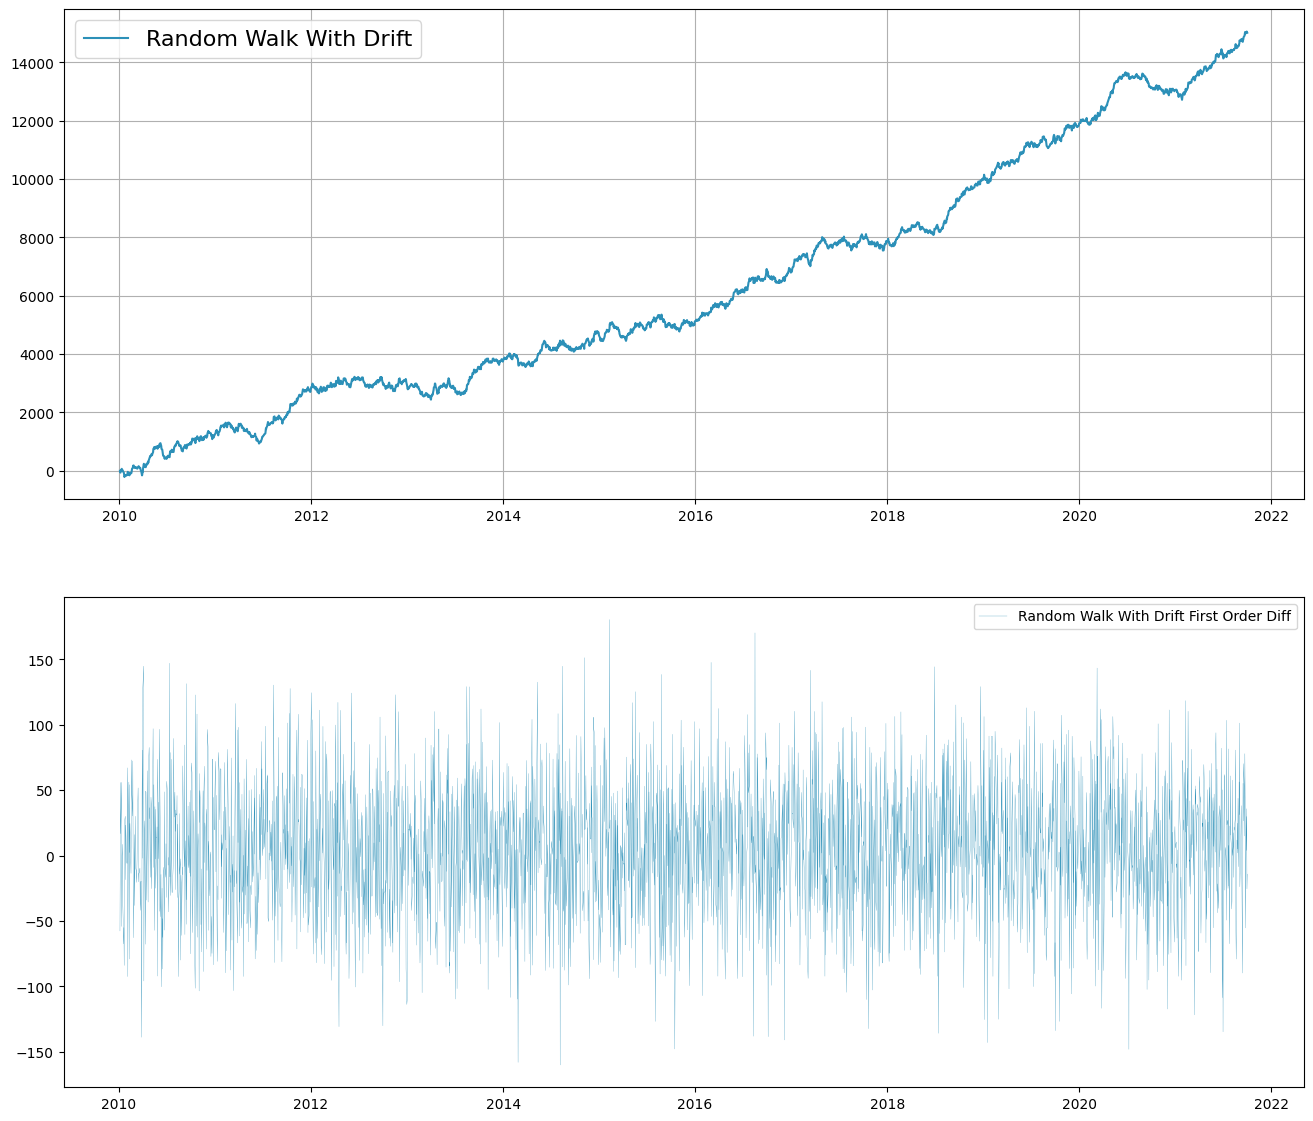

In [38]:
df_rw = pd.DataFrame(rw, index = df.index, columns = ['Simulated Asset Price'])
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 14))
ax[0].plot(df_rw, color = '#2c90b8', label = 'Random Walk With Drift')
ax[1].plot(df_rw.diff().dropna(), color = '#2c90b8', label = 'Random Walk With Drift First Order Diff', lw =.2)
ax[0].grid()
ax[0].legend(fontsize = 16)
ax[1].legend()
plt.show()

$\rho=1$ байхад үүнийг unit root асуудал гэж нэрлэдэг тул nonstationarity, random walk, unit root, болон stochastic trend гэсэн нэр томъёог ижил утгаар авч үзэж болно.

Бид дараах хувиргалтыг хийж болно:
$$
\left(Y_{t}-Y_{t-1}\right)=\Delta Y_{t}=\beta_{1}+u_{t}
$$

Энэ нь мөн DSP боловч хэрэв $\beta\neq 0$ бол эхний ялгаа нь эерэг эсвэл сөрөг хандлагыг харуулдаг бөгөөд үүнийг **стохастик тренд** гэж нэрлэдэг.

### <font face="gotham" color="purple"> Trend Stationary Process </font>

Тренд стационар загвар:
$$
Y_{t}=\beta_{1}+\beta_{2} t+u_{t}
$$
Хэрэв бид $Y_t$-ээс $E(Y_t)$-ийг хасвал үр дүнд нь гарсан цуваа stationary байх тул энэ нь **trend stationary process** (TSP) болно. $AR(1)$ бүрэлдэхүүнтэй детерминист тренд нь дараах байдалтай болно
$$
Y_{t}=\beta_{1}+\beta_{2} t+\beta_{3} Y_{t-1}+u_{t}
$$

## <font face="gotham" color="purple"> Integrated Stochastic Processes </font>

Аливаа хугацаан цувааны нэгдүгээр эрэмбийн ялгавартай болсны дараа бид үүнийг $Y_t\sim I(1)$ гэж тэмдэглэж, 1-р эрэмбийн интегрэйтед гэж нэрлэдэг. Хэрэв хугацаан цуваа stationary байхын тулд 2 удаа ялгавар авах шаардлагатай бол $Y_t\sim I(2)$ гэж тэмдэглэж 2-р эрэмбийн интегрэйтед хугацаан цуваа гэж нэрлэдэг.

Эдийн засаг, санхүүгийн цагийн цувааны ихэнх нь $I(1)$.

## <font face="gotham" color="purple"> Spurious Regression </font>

**Хуурамч регресс**-ийг ойлгох хамгийн сайн арга бол хоёр санамсаргүй алхалтын цуврал үүсгэж, дараа нь нэгийг нөгөө рүү регресс болгох явдал юм. $Y_t$ ба $X_t$ хоёр хөрөнгийн үнийг дуурайцгаая. 

\begin{aligned}
Y_{t} &= \alpha_1+\alpha_2 Y_{t-1}+u_{t} \\
X_{t} &=\beta_1+\beta_2 X_{t-1}+v_{t}
\end{aligned}

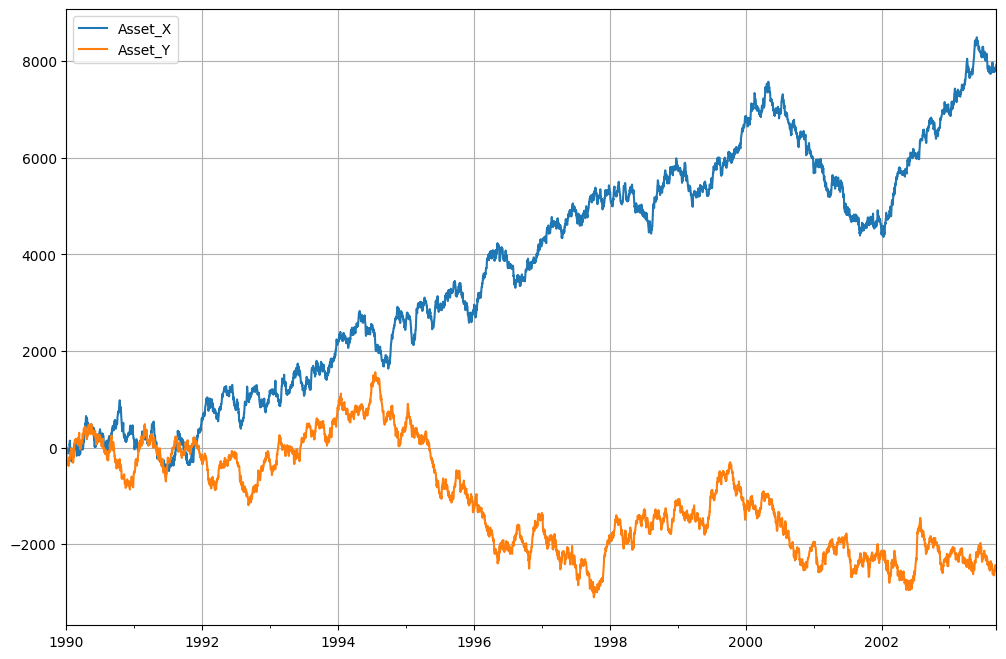

In [39]:
def rw_dr(dr_param, slope_param, init_val, length):
    rw_array = []
    rw_array.append(init_val)
    
    last = init_val
    for i in range(length):
        current = dr_param + slope_param*last + 50*np.random.randn()
        rw_array.append(current)
        last = current
    return rw_array

N = 5000
X = rw_dr(2, 1, 0, N)
Y = rw_dr(0, 1, 0, N)
dates = pd.date_range("19900101", periods=N+1)

df = pd.DataFrame([X, Y]).T
df.columns = ['Asset_X', 'Asset_Y']
df.index = dates
df.plot(figsize = (12, 8), grid=True); plt.show()

In [40]:
model = smf.ols(formula='Asset_Y ~ Asset_X', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Asset_Y   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     6075.
Date:                Tue, 27 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:01:03   Log-Likelihood:                -40032.
No. Observations:                5001   AIC:                         8.007e+04
Df Residuals:                    4999   BIC:                         8.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    149.5315     18.820      7.945      0.0

$X$-ийн $t$-статистик нь маш чухал бөгөөд $R^2$ нь харьцангуй бага боловч $F$-статистик нь маш чухал гэдгийг анхаарна уу. 

$X$ ба $Y$-ийн өгөгдөл үүсгэх үйл явц нь хоорондоо хамааралгүй боловч регрессийн үр дүн нь хамааралтай харуулж байна. Энэ бол хуурамч регрессийн үзэгдэл юм. $dw$  бараг $0$ байгааг харж болно, энэ нь хүчтэй автокорреляцийн асуудал байгааг харуулж байна.

$R^2 > dw$ нь үнэлсэн регрессийг хуурамч гэж сэжиглэх сайн дүрэм юм. Түүнчлэн, $t$-статистикийг $t$-тархалтаар тараадаггүй тул бүх статистик тестүүд хүчингүй гэдгийг анхаарна уу.

## <font face="gotham" color="purple"> Tests Of Stationarity </font>

### <font face="gotham" color="purple"> Autocorrelation Function and Correlogram </font>

$k$ лаг дахь автокорреляцийн функц (ACF) дараах байдлаар тодорхойлогддог:
\begin{aligned}
\rho_{k} &=\frac{\gamma_{k}}{\gamma_{0}}=\frac{\text { covariance at lag } k}{\text { variance }}
\end{aligned}
Практикт бид зөвхөн түүврийн автокорреляцийн функцийг тооцоолж чадна, $\hat{\rho}_k$
\begin{aligned}
&\hat{\gamma}_{k}=\frac{\sum\left(Y_{t}-\bar{Y}\right)\left(Y_{t+k}-\bar{Y}\right)}{n-k} \\
&\hat{\gamma}_{0}=\frac{\sum\left(Y_{t}-\bar{Y}\right)^{2}}{n-1}
\end{aligned}
Энд $\hat{\rho}_0 = 1$.

Хэрэв бид $\hat{\rho}$-ийг $k$-ийн эсрэг зурсанаар коррелограммыг гаргаж авч чадна. Энд цагаан шуугианы коррелограмм дүрсэллээ.

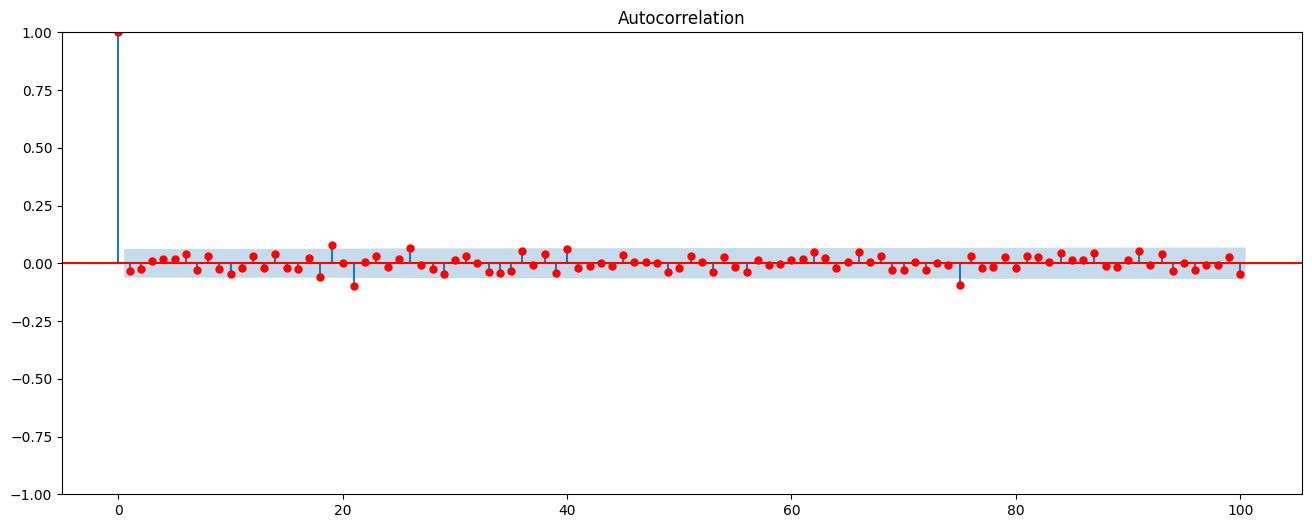

In [41]:
from statsmodels.graphics import tsaplots
X = np.random.randn(1000)
plot_acf(X, lags=100, color = 'red').set_size_inches(16,6)
plt.show()

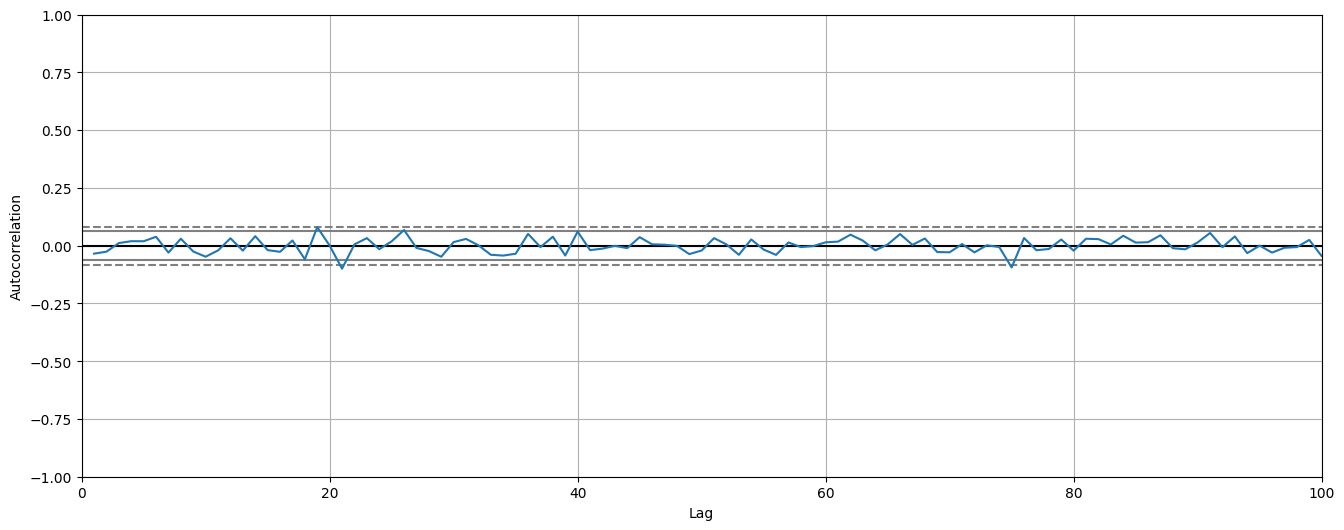

In [42]:
plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(X).set_xlim([0, 100])
plt.show()

Төрөл бүрийн lag дахь автокорреляци $0$ орчим байдаг нь stationarity байдлын шинж тэмдэг юм.
АНУ-ын хэрэглэгчдийн сар бүрийн CPI-ийн коррелограммыг энд харуулав. Эконометрик дэх хуучин уламжлал бол ACF-ийг хугацааны цувааны $1/3$  хүртэлх хугацаанд тооцож шалгадаг.

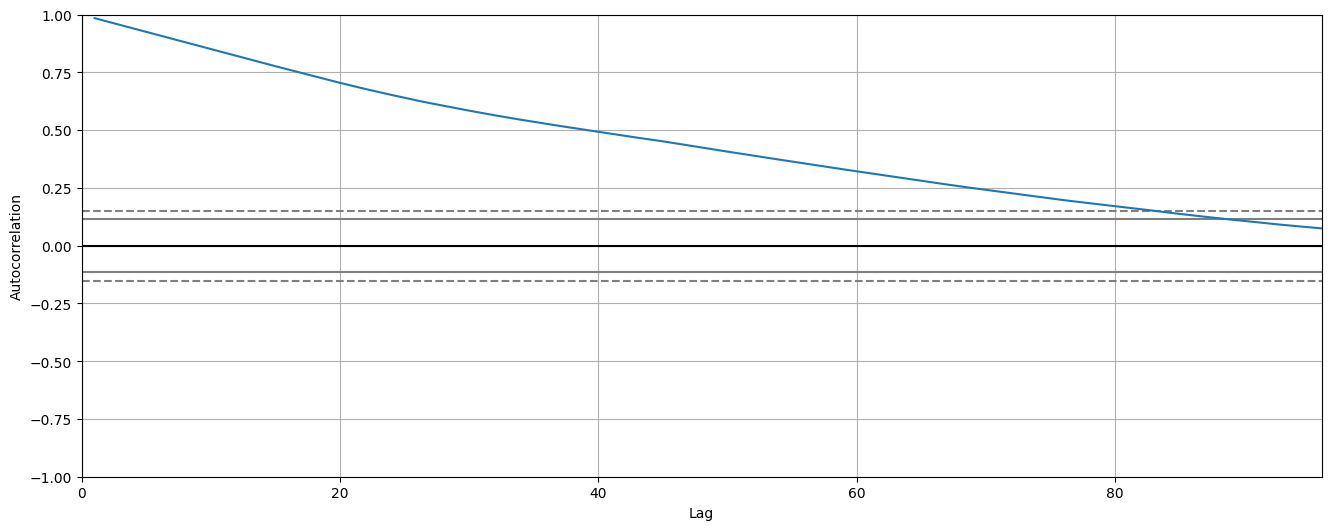

In [43]:
df= pdr.data.DataReader(['CPIAUCSL'], 'fred' , start, end)
df.columns = ['CPI_Urban']

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(df['CPI_Urban']).set_xlim([0, np.round(len(df)/3)])
plt.show()

### <font face="gotham" color="purple"> Dickey–Fuller (DF) test </font>

Хэрэв бид $Y_t$-г unit root process гэж үзвэл бид $Y_{t-1}$-ийг $Y_t$-ээр тайлбарлаж болох энгийн регрессийг үнэлж болох байсан 
$$
Y_{t}=\rho Y_{t-1}+u_{t} \quad-1 \leq \rho \leq 1
$$
Гэхдээ асуудал нь хэрэв $\rho=1$ байвал $t$-статистик гажилттай гарна. 

Гэхдээ зарим хувиргалт нь энэхүү асуудлыг шийдэх боломжтой:
\begin{aligned}
Y_{t}-Y_{t-1} &=\rho Y_{t-1}-Y_{t-1}+u_{t} \\
&=(\rho-1) Y_{t-1}+u_{t}\\
\Delta Y_t &= \delta Y_{t-1}+u_{t}
\end{aligned}
энд $\delta = \rho-1$. Хэрэв $\delta =0$, $\rho=1$ бол $\Delta Y_t = u_t$, эндээс $Y_t$ бол stationarity биш; Хэрэв $\delta <0$, бол $\rho <1$, энэ үед $y_t$ бол stationary.

Сүүлийн тэгшитгэлийн хувьд $\Delta Y_t = \delta Y_{t-1}+u_{t}$ бол the one to estimate and hypotheses are 
$$
H_0: \delta = 0, \text{unstationary}\\
H_1: \delta < 0, \text{stationary}
$$

It turns out the $t$-statistic calculated on $\delta$ doesn't really follow a $t$-distribution, it actually follows $\tau$-distribution or **Dickey-Fuller distribution**, therefore we call it _Dickey-Fuller test_.

In [44]:
from statsmodels.tsa.stattools import adfuller

In [45]:
results_dickeyfuller = adfuller(X)
print('ADF Statistic: %f' %results_dickeyfuller[0])
print('p-value: %f' %results_dickeyfuller[1])

ADF Statistic: -32.751388
p-value: 0.000000
